In [5]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import einsum
import einops
from tqdm.notebook import tqdm
import seaborn as sns
from transformer_lens import HookedTransformer
from datasets import load_dataset
from einops import einsum


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
model = HookedTransformer.from_pretrained("tiny-stories-1M", device=device)
model.cfg

Using pad_token, but it is not set yet.


Loaded pretrained model tiny-stories-1M into HookedTransformer


HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_types': ['global',
                'local',
                'global',
                'local',
                'global',
                'local',
                'global',
                'local'],
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 4,
 'd_mlp': 256,
 'd_model': 64,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'device': 'cuda',
 'eps': 1e-05,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.1,
 'model_name': 'TinyStories-1M',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 16,
 'n_layers': 8,
 'n_params': 393216,
 'normalization_type': 'LNPre',
 'original_architecture': 'GPTNeoForCausalLM',
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'rotary_dim': None,
 'scale_attn_by_inverse_layer_idx': False,
 'seed': None,
 

In [74]:
dataset = load_dataset('roneneldan/TinyStories', split='train', streaming=True)
shuffled_dataset = dataset.shuffle(seed=1)
train_dataloader = torch.utils.data.DataLoader(shuffled_dataset, batch_size=16)

In [91]:
valid_dataset = load_dataset('roneneldan/TinyStories', split='validation', streaming=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)

In [6]:
model.to(device)

Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (h

In [77]:
def get_random_batch(hook_point="blocks.0.mlp.hook_post"):
    for i, batch in enumerate(train_dataloader):
        text_input = batch["text"]
        logits, cache = model.run_with_cache(text_input)
        return cache[hook_point]

In [8]:
h = model.cfg.d_mlp
G = model.cfg.d_mlp * 2

class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Linear(h, G)
    self.decoder = torch.nn.Linear(G, h, bias=False)

    torch.nn.init.orthogonal_(self.decoder.weight)


  def forward(self, x):
    hidden = F.relu(self.encoder(x))
    
    # each h dimension should sum to 1, we use an L2 norm to achieve this
    # print(self.decoder.weight.shape) # [h, G]
    l2_norm = torch.sum(self.decoder.weight**2, axis=0)**(0.5)  # [n_points]
    normalized_decoder_weights = self.decoder.weight / l2_norm
    x = hidden @ normalized_decoder_weights.T
    return (x, hidden)

In [12]:
from torch.optim import lr_scheduler
autoencoder = Autoencoder()
autoencoder.to(device)
optim = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

criterion = torch.nn.MSELoss()
# l1 = torch.nn.L1Loss()
alpha = 0.0001

batch_size = 256
phi = 5

losses = []

for i in tqdm(range(1000)):
    data = get_random_batch()

    # Step 2: train
    optim.zero_grad()
    x, hidden = autoencoder(data)

    #l1_loss = sum(1 / G * alpha * torch.linalg.vector_norm(hidden, dim=1, ord=1))
    l1_loss = (1/G)*alpha*torch.sum(torch.abs(hidden))
    crit_loss = criterion(x, data)

    loss = crit_loss + l1_loss
    loss.backward()
    optim.step()
    losses.append(loss.item())

    if (i+1)%10 == 0:
        print(f"Batch {i+1}, criterion_loss={np.round(crit_loss.item(), 6)}, l1_loss={np.round(l1_loss.item(), 6)}")
        print((torch.sum(hidden > 0) / batch_size).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Batch 10, criterion_loss=0.0087, l1_loss=0.0077
1814.7578125
Batch 20, criterion_loss=0.0055, l1_loss=0.006
1284.18359375
Batch 30, criterion_loss=0.0043, l1_loss=0.0051
1012.109375
Batch 40, criterion_loss=0.0033, l1_loss=0.0046
901.875
Batch 50, criterion_loss=0.0026, l1_loss=0.0041
767.38671875
Batch 60, criterion_loss=0.0021, l1_loss=0.0038
642.2265625
Batch 70, criterion_loss=0.0017, l1_loss=0.0034
556.3046875
Batch 80, criterion_loss=0.0015, l1_loss=0.0031
407.52734375
Batch 90, criterion_loss=0.0013, l1_loss=0.003
333.03515625
Batch 100, criterion_loss=0.0012, l1_loss=0.0029
294.30078125
Batch 110, criterion_loss=0.0011, l1_loss=0.0028
260.3671875
Batch 120, criterion_loss=0.001, l1_loss=0.0028
245.9140625
Batch 130, criterion_loss=0.001, l1_loss=0.0028
231.5625
Batch 140, criterion_loss=0.0009, l1_loss=0.0028
222.0859375
Batch 150, criterion_loss=0.0009, l1_loss=0.0027
212.69921875
Batch 160, criterion_loss=0.0008, l1_loss=0.0027
205.6171875
Batch 170, criterion_loss=0.0008, l1

In [78]:
def insert_autoencoder_hook(value, hook):
        return torch.zeros_like(value)
        x, _ = autoencoder(value)
        return x

with torch.no_grad():
    layer_to_ablate = 0
    total_original_loss = 0
    total_ablated_loss = 0
    for i, batch in enumerate(valid_dataloader):
        data = batch["text"]
        original_loss = model(data, return_type="loss")
        ablated_loss = model.run_with_hooks(
            data, 
            return_type="loss", 
            fwd_hooks=[(
                f"blocks.{layer_to_ablate}.mlp.hook_post", 
                insert_autoencoder_hook
                )]
            )
        total_original_loss += original_loss.item()
        total_ablated_loss += ablated_loss.item()
        #print(f"Original Loss: {original_loss.item():.3f}")
        #print(f"Ablated Loss: {ablated_loss.item():.3f}")
        if i == 100:
            break

    print("Layer:", layer_to_ablate)
    print(total_original_loss)
    print(total_ablated_loss)

Layer: 0
543.0510387420654
683.5119590759277


In [92]:
def ablate_mlp_hook(value, hook):
    return torch.zeros_like(value)
    value = mean_cache
    return value
    return torch.zeros_like(value)

with torch.no_grad():
    total_original_loss = {i:0 for i in range(7)}
    total_ablated_loss = {i:0 for i in range(7)}
    for layer_to_ablate in range(7):
        model.reset_hooks()
        for i, batch in enumerate(valid_dataloader):
            data = batch["text"]
            original_loss = model(data, return_type="loss")
            ablated_loss = model.run_with_hooks(
                data, 
                return_type="loss", 
                fwd_hooks=[(
                    f"blocks.{layer_to_ablate}.mlp.hook_post", 
                    insert_autoencoder_hook
                    )]
                )
            total_original_loss[layer_to_ablate] += original_loss.item()
            total_ablated_loss[layer_to_ablate] += ablated_loss.item()
            if i == 100:
                break

        print("Layer:", layer_to_ablate)
        print(total_original_loss[layer_to_ablate])
        print(total_ablated_loss[layer_to_ablate])

Layer: 0
577.3156080245972
592.9109387397766
Layer: 1
577.3156080245972
561.3409523963928
Layer: 2
577.3156080245972
606.9268655776978
Layer: 3
577.3156080245972
991.4842863082886
Layer: 4
577.3156080245972
528.2562704086304
Layer: 5
577.3156080245972
588.4724946022034
Layer: 6
577.3156080245972
685.7214698791504


In [15]:
#torch.manual_seed(0)
#np.random.seed(0)

def ablate_mlp_hook(value, hook):
    return torch.zeros_like(value)

valid_dataset = load_dataset('roneneldan/TinyStories', split='validation', streaming=True)
valid_dataset = valid_dataset.shuffle()
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)

with torch.no_grad():
    def get_log_probs(logits, tokens):
        log_probs = logits.log_softmax(dim=-1)
        # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
        log_probs_for_tokens = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)

        return log_probs_for_tokens

    layer_to_ablate = 0
    pred_log_probs = []
    real_loss = []
    total_ablated_loss = []
    for i, batch in enumerate(valid_dataloader):
        data = batch["text"]
        tokens = model.to_tokens(data)

        embedded = model.embed.W_E[tokens, :]
        unembed = einsum(embedded, model.unembed.W_U, 'batch pos d_model, d_model d_vocab -> \
            batch pos d_vocab') + model.unembed.b_U
        pred_log_probs.append(-get_log_probs(unembed, tokens).mean().item())

        loss = model(tokens, return_type="loss").item()
        real_loss.append(loss)

        ablated_loss = model.run_with_hooks(
                tokens, 
                return_type="loss", 
                fwd_hooks=[(
                    f"blocks.{layer_to_ablate}.mlp.hook_post", 
                    ablate_mlp_hook
                    )]
                )
        total_ablated_loss.append(ablated_loss.item())
        
    print(f"Embedding only loss: {np.mean(pred_log_probs):.6f}")
    print(f"Full model loss: {np.mean(real_loss):.6f}")
    print(f"Ablated MLP layer {layer_to_ablate} loss: {np.mean(total_ablated_loss):.6f}")

Embedding only loss: 5.962310
Full model loss: 5.878995
Ablated MLP layer 0 loss: 5.575937


In [10]:
import pandas as pd

In [21]:
dfs = [pd.DataFrame({"loss": total_ablated_loss, "name": "Ablated"}), 
        pd.DataFrame({"loss": real_loss, "name": "FullModel"}),
        pd.DataFrame({"loss": pred_log_probs, "name": "EmbeddingOnly"})]
df = pd.concat(dfs)
df.groupby("name").agg(["mean", "std"])

loss          
                   mean       std
name                             
Ablated        5.575937  1.014684
EmbeddingOnly  5.962310  0.165729
FullModel      5.878995  0.364719

<Axes: xlabel='loss', ylabel='Probability'>

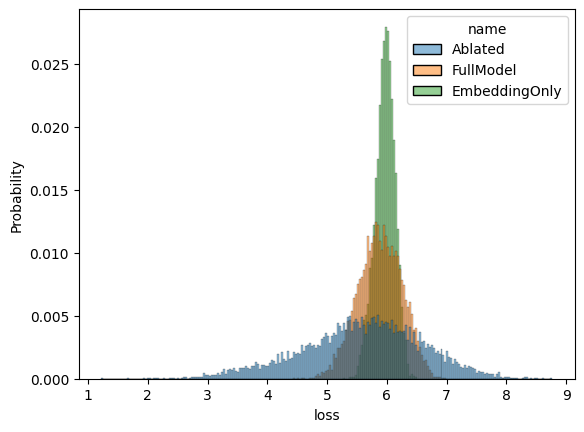

In [20]:
sns.histplot(df, x="loss", hue="name", stat="probability")